In [1]:
%matplotlib inline


In [10]:
# Set the correct working directory
import os
# if 'paper_exp' in os.path.abspath(os.curdir).split('/'):
#     while os.path.abspath(os.curdir).split('/')[-1] != 'paper_exp':
#         os.chdir(os.pardir)
#     os.chdir(os.pardir)
print("current working directory: {}".format(os.path.abspath(os.getcwd())))

current working directory: /scratch/ssd001/home/huang/git_code/lae/linear-ae


In [11]:
import wandb
import matplotlib.pyplot as plt
import seaborn
import numpy as np

In [4]:
from models.model_config import ModelTypes

In [5]:
api = wandb.Api()

In [6]:
algo_names= ["RMSprop_full","SGD","rmsprop_subspace"]
# model_names = ["deterministic_nd", "nd", ModelTypes.NON_UNIFORM_SUM, ModelTypes.ROTATION, ModelTypes.VAE]

model_to_metric = {model_type: model_type for model_type in ModelTypes.VALID_MODEL_TYPES}
model_to_metric[ModelTypes.NESTED_DROPOUT] = 'nd_expectation'
# model_to_label = {name: name for name in model_names}
# model_to_label[ModelTypes.NESTED_DROPOUT] = 'nested_dropout (expectation)'

In [7]:
hdims = [20,200,500]
optimal_lrs = {
    "nd_exp": {
        "SGD": {dim: 0.001 for dim in hdims},
        "Adam": {
            2: 0.003,
            5: 0.003,
            10: 0.003,
            20: 0.003,
            50: 0.003,
            100: 0.01,
            200: 0.01,
            300: 0.01,
            400: 0.01,
            500: 0.01
        }
    },
    "nd": {
        "SGD": {dim: 0.001 for dim in hdims},
        "Adam": {
            2: 0.01,
            5: 0.01,
            10: 0.01,
            20: 0.01,
            50: 0.003,
            100: 0.003,
            200: 0.003,
            300: None,
            400: None,
            500: 0.003
        }
    },
    ModelTypes.NON_UNIFORM_SUM: {
        "SGD": {dim: 0.001 for dim in hdims},
        "Adam": {dim: 0.003 for dim in hdims}
    },
    ModelTypes.ROTATION: {
        "SGD": {
            2: 0.0001,
            5: 0.0001,
            10: 0.0001,
            20: 0.0001,
            50: 0.0001,
            100: 0.0001,
            200: 0.0001,
            300: 0.0001,
            400: 0.0001,
            500: 0.0001
        },
        "Adam": {dim: 0.0003 for dim in hdims}
    },
    ModelTypes.UNIFORM_SUM: {
        "SGD": {dim: 0.001 for dim in hdims},
        "Adam": {dim: 0.003 for dim in hdims}
    },
    ModelTypes.VAE: {
        "SGD": {dim: 0.0003 for dim in hdims},
        "Adam": {
            2: 0.003,
            5: 0.003,
            10: 0.003,
            20: 0.003,
            50: 0.001,
            100: 0.001,
            200: 0.001,
            300: None,
            400: None,
            500: 0.001
        }
    }
}


In [8]:
all_runs = {"RMSprop_full":{},"SGD":{}, "rmsprop_subspace": {}}
histories = {"RMSprop_full":{},"SGD":{}, "rmsprop_subspace": {}}

In [9]:
# get run data from wandb
for name in model_names:
    if name == "deterministic_nd":
        model_type = ModelTypes.NESTED_DROPOUT
        optim_hdim_lrs = optimal_lrs['nd_exp']
        # extra_filters = {'nd_expectation': True}
    elif name == "nd":
        model_type = ModelTypes.NESTED_DROPOUT
        optim_hdim_lrs = optimal_lrs['nd']
        # extra_filters = {'nd_expectation': False}
    else:
        model_type = name
        optim_hdim_lrs = optimal_lrs[model_type]
        # extra_filters = {}
    
    for optimizer in ['SGD', 'Adam']:
        print("=> Getting data for {} with {}".format(model_type, optimizer))
        all_runs[optimizer][name] = {}
        for hdim in hdims:
            filters = {'config.model_type': model_type, 
                       'config.hdim': hdim,
                       'config.train_itr': 50000,
                       'config.lr': optim_hdim_lrs[optimizer][hdim],
                       # **extra_filters
                       }
            runs = api.runs('xuchanbao/fig4_synth_1k', filters=filters)
            
            if name == 'deterministic_nd':
                filtered_runs = []
                for run in runs:
                    if run.config['nd_expectation'] == 'true':
                        filtered_runs.append(run)
            elif name == 'nd':
                filtered_runs = []
                for run in runs:
                    if run.config['nd_expectation'] == 'false':
                        filtered_runs.append(run)
            else:
                filtered_runs = runs
            if len(filtered_runs) == 1:
                all_runs[optimizer][name][hdim] = filtered_runs[0]
            else:
                print("Warning: {} runs found with {}, {}, hdim {}".format(len(filtered_runs), optimizer, name, hdim))
                for run in filtered_runs:
                    if "paper" in run.tags:
                        print("Accept run {} with tag 'paper'".format(run.id))
                        all_runs[optimizer][name][hdim] = run
                        break

=> Getting data for nested_dropout with SGD
=> Getting data for nested_dropout with Adam
Accept run 4u97z004 with tag 'paper'
=> Getting data for nested_dropout with SGD
=> Getting data for nested_dropout with Adam
=> Getting data for non_uniform_sum with SGD
=> Getting data for non_uniform_sum with Adam
=> Getting data for rotation with SGD
=> Getting data for rotation with Adam
=> Getting data for vae with SGD
=> Getting data for vae with Adam


In [10]:
for optimizer, optim_runs in all_runs.items():
    for name, runs_hdims in optim_runs.items():
        for hdim, run in runs_hdims.items():
            assert 'paper' in run.tags, "run {} doesn't have tag 'paper'".format(run.id)
            histories[optimizer][name][hdim] = run.history()

In [11]:
def draw_scatterplot(cutoff, all_hdims):
    all_curves = {'SGD': {name: {"hdim": [], "smallest_epoch": []} for name in model_names}, 
                  'Adam': {name: {"hdim": [], "smallest_epoch": []} for name in model_names}}

    for optimizer in ['SGD', 'Adam']:
        for hdim in hdims:
            for name in model_names:
                if hdim not in histories[optimizer][name].keys():
                    continue
                history_i = histories[optimizer][name][hdim]#.fillna(1.0)
                model_type = all_runs[optimizer][name][hdim].config['model_type']
                
                cutoff_indices = history_i[history_i['axis-alignment/{}'.format(model_to_metric[model_type])].astype(np.float).le(cutoff)].index
                if len(cutoff_indices) > 0:
                    all_curves[optimizer][name]['hdim'].append(hdim)
                    all_curves[optimizer][name]['smallest_epoch'].append(history_i['_step'][cutoff_indices[0]])  # first index below cutoff
    colors = {
        ModelTypes.NON_UNIFORM_SUM: 'tab:blue',
        ModelTypes.ROTATION: 'tab:green',
        'nd': 'tab:red',
        'deterministic_nd': 'tab:orange',
        ModelTypes.VAE: 'tab:purple'
    }
    
    mark_shapes = {
        'SGD': '-o',
        'Adam': '--o'
    }
    end_shapes = {
        'SGD': '-',
        'Adam': '--'
    }
    
    with seaborn.axes_style('darkgrid'):
        for optimizer in ['SGD', 'Adam']:
            for name in list(colors.keys()):
                epochs = []
                
                curves_hdims = all_curves[optimizer][name]
                if optimizer == 'SGD': 
                    plt.plot(curves_hdims['hdim'][:-1], curves_hdims['smallest_epoch'][:-1], mark_shapes[optimizer], 
                             label=name, color=colors[name])
                else:
                    # no label
                    plt.plot(curves_hdims['hdim'][:-1], curves_hdims['smallest_epoch'][:-1], mark_shapes[optimizer],
                             color=colors[name])
                plt.plot(curves_hdims['hdim'][-2:], curves_hdims['smallest_epoch'][-2:], end_shapes[optimizer], 
                         color=colors[name])
                
                if len(curves_hdims['hdim']) == 0:
                    continue
                last_hdim = curves_hdims['hdim'][-1]
                last_epoch = curves_hdims['smallest_epoch'][-1]

                if all_hdims[-1] not in curves_hdims['hdim']:
                    last_hdim = curves_hdims['hdim'][-1]
                    last_epoch = curves_hdims['smallest_epoch'][-1]
                    plt.scatter([last_hdim], [last_epoch], s=50, linewidth=3, marker='x', color=colors[name])
    
                else:
                    plt.scatter([last_hdim], [last_epoch], marker='o', color=colors[name])
        plt.legend(loc='lower right')
        plt.ylim(10, 200000)
        plt.xlim(1.5, all_hdims[-1] * 1.5)
        plt.xlabel("Hidden dimension")
        plt.ylabel('Epoch')
        plt.yscale('log')
        plt.xscale('log')
#         plt.title('Epochs to reach {} axis-alignment distance'.format(cutoff))
        plt.savefig('plots/paper/fig4_{}.pdf'.format(cutoff), bbox_inches = 'tight')

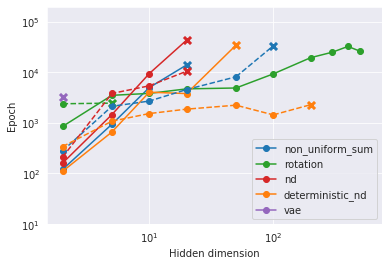

In [12]:
draw_scatterplot(0.25, hdims)

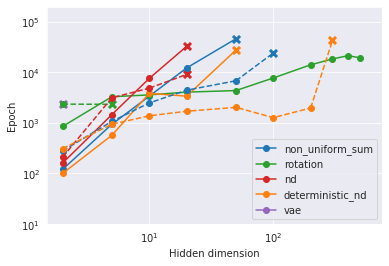

In [13]:
draw_scatterplot(0.28, hdims)

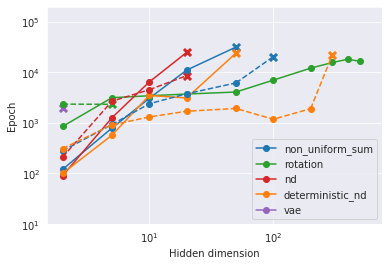

In [14]:
draw_scatterplot(0.30, hdims)